In [ ]:
!pip install facenet-pytorch

In [ ]:
import pandas as pd
import shutil
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import sys
import os
import time
import torch.nn.functional as F
import os
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization, training

In [ ]:
data_transforms = transforms.Compose([
        np.float32,
        transforms.ToTensor(),
        fixed_image_standardization
])

image_dataset = datasets.ImageFolder('/content/trial_set_final/trial_set',  data_transforms)

In [ ]:
os.listdir('/content/trial_set_final/trial_set')
os.remove(os.path.join('/content/trial_set_final/trial_set', '.DS_Store' ))

In [ ]:
len(os.listdir('/content/trial_set_final/trial_set'))

30

In [ ]:
img_inds = np.arange(len(image_dataset))

In [ ]:
np.random.shuffle(img_inds)

In [ ]:
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from facenet_pytorch import InceptionResnetV1


In [ ]:
train_loader = DataLoader(
    image_dataset,
    num_workers=2,
    batch_size=20,
    sampler=SubsetRandomSampler(train_inds),
    drop_last=True
)
val_loader = DataLoader(
    image_dataset,
    num_workers=2,
    batch_size=20,
    sampler=SubsetRandomSampler(val_inds),
    drop_last=True
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'acc': training.accuracy
}

In [ ]:
 def complete_epoch(model, loss_fn, loader, optimizer=None, scheduler=None,  batch_metrics=metrics, device=device):   
    mode = 'Train' if model.training else 'Valid'
    print(mode)
    loss = 0
    metrics = {}
    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)

        loss_batch = loss_fn(y_pred, y)
        

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()


        
        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
            metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            

        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}

    return loss, metrics

In [ ]:
len(image_dataset.class_to_idx)

30

In [ ]:
image_dataset.class_to_idx

{'A._Griezmann_football': 0,
 'A._Laporte_football': 1,
 'Alisson_football': 2,
 'Bernardo_Silva_football': 3,
 'Cristiano_Ronaldo_football': 4,
 'David_Silva_football': 5,
 'De_Gea_football': 6,
 'E._Hazard_football': 7,
 'H._Kane_football': 8,
 'H._Son_football': 9,
 'K._Benzema_football': 10,
 'K._De_Bruyne_football': 11,
 'K._Mbappe╠ü_football': 12,
 'L._Messi_football': 13,
 'L._Modric╠ü_football': 14,
 'L._Sua╠ürez_football': 15,
 'M._Neuer_football': 16,
 'M._Salah_football': 17,
 'N._Kante╠ü_football': 18,
 'Neymar_Jr_football': 19,
 'P._Aubameyang_football': 20,
 'P._Pogba_football': 21,
 'Pique╠ü_football': 22,
 'R._Lewandowski_football': 23,
 'S._Agu╠êero_football': 24,
 'S._Mane╠ü_football': 25,
 'Sergio_Ramos_football': 26,
 'T._Kroos_football': 27,
 'Thiago_Silva_football': 28,
 'V._van_Dijk_football': 29}

In [ ]:
from facenet_pytorch import InceptionResnetV1

resnet = InceptionResnetV1(
    classify=True,
    num_classes=len(image_dataset.class_to_idx)
).to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)


In [ ]:
torch.load('/content/gdrive/MyDrive/resnet_model_best_weights/model_best.pt')

{'model_state_dict': OrderedDict([('conv2d_1a.conv.weight',
               tensor([[[[ 5.9824e-02,  1.7953e-01,  2.8926e-01],
                         [-3.7600e-02,  7.0271e-02,  1.3611e-01],
                         [-2.1849e-01, -8.6169e-02, -1.3002e-02]],
               
                        [[ 2.2355e-02,  1.8516e-01,  3.1012e-01],
                         [-9.2252e-02,  5.4475e-02,  1.4013e-01],
                         [-3.0034e-01, -1.3172e-01, -3.9770e-02]],
               
                        [[ 9.2837e-02,  2.0002e-01,  3.2233e-01],
                         [-1.8695e-02,  7.3924e-02,  1.5134e-01],
                         [-2.5090e-01, -1.1609e-01, -3.9765e-02]]],
               
               
                       [[[-2.0792e-01, -9.2688e-02, -9.4617e-02],
                         [ 1.2252e-02,  7.9317e-02,  8.9089e-02],
                         [ 1.5763e-01,  2.2229e-01,  2.7606e-01]],
               
                        [[-2.4610e-01, -1.2089e-01, -1.3046e-01

In [ ]:
resnet.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet_model_best_weights/model_best.pt')['model_state_dict'])

<All keys matched successfully>

In [ ]:
import pickle
file_save = open("ids_to_player.pkl", "wb")
pickle.dump(image_dataset.class_to_idx, file_save)
file_save.close()


In [ ]:
a_file = open("/content/ids_to_player.pkl", "rb")
output = pickle.load(a_file)
print(output)

{0: 'A._Griezmann_football', 1: 'A._Laporte_football', 2: 'Alisson_football', 3: 'Bernardo_Silva_football', 4: 'Cristiano_Ronaldo_football', 5: 'David_Silva_football', 6: 'De_Gea_football', 7: 'E._Hazard_football', 8: 'H._Kane_football', 9: 'H._Son_football', 10: 'K._Benzema_football', 11: 'K._De_Bruyne_football', 12: 'K._Mbappe╠ü_football', 13: 'L._Messi_football', 14: 'L._Modric╠ü_football', 15: 'L._Sua╠ürez_football', 16: 'M._Neuer_football', 17: 'M._Salah_football', 18: 'N._Kante╠ü_football', 19: 'Neymar_Jr_football', 20: 'P._Aubameyang_football', 21: 'P._Pogba_football', 22: 'Pique╠ü_football', 23: 'R._Lewandowski_football', 24: 'S._Agu╠êero_football', 25: 'S._Mane╠ü_football', 26: 'Sergio_Ramos_football', 27: 'T._Kroos_football', 28: 'Thiago_Silva_football', 29: 'V._van_Dijk_football'}


In [ ]:
dic = {value:key for key, value in output.items()}

In [ ]:
a_file = open("/content/ids_to_player.pkl", "wb")
pickle.dump(dic, a_file)
a_file.close()


In [ ]:
for p in resnet.named_parameters():
    p[1].requires_grad = False


In [ ]:
resnet.logits.weight.requires_grad = True
resnet.logits.bias.requires_grad = True

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'acc': training.accuracy
}


In [ ]:
list(resnet.named_parameters())

[('conv2d_1a.conv.weight', Parameter containing:
  tensor([[[[ 5.9824e-02,  1.7953e-01,  2.8926e-01],
            [-3.7600e-02,  7.0271e-02,  1.3611e-01],
            [-2.1849e-01, -8.6169e-02, -1.3002e-02]],
  
           [[ 2.2355e-02,  1.8516e-01,  3.1012e-01],
            [-9.2252e-02,  5.4475e-02,  1.4013e-01],
            [-3.0034e-01, -1.3172e-01, -3.9770e-02]],
  
           [[ 9.2837e-02,  2.0002e-01,  3.2233e-01],
            [-1.8695e-02,  7.3924e-02,  1.5134e-01],
            [-2.5090e-01, -1.1609e-01, -3.9765e-02]]],
  
  
          [[[-2.0792e-01, -9.2688e-02, -9.4617e-02],
            [ 1.2252e-02,  7.9317e-02,  8.9089e-02],
            [ 1.5763e-01,  2.2229e-01,  2.7606e-01]],
  
           [[-2.4610e-01, -1.2089e-01, -1.3046e-01],
            [-3.9564e-03,  7.9825e-02,  8.5580e-02],
            [ 1.2087e-01,  2.0506e-01,  2.5370e-01]],
  
           [[-2.1682e-01, -1.2305e-01, -1.3316e-01],
            [ 1.1448e-02,  5.7706e-02,  6.2719e-02],
            [ 2.0375e-01, 

In [ ]:
best_loss = np.inf
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
no_improvement = 0
for epoch in range(40):
  resnet.train()
  p_count = 0
  for p in resnet.named_parameters():
      if p_count >= len(list(resnet.named_parameters()))-2-3*epoch:
          p[1].requires_grad = True
          print('Tracking Gradient For:', p[0])
      p_count += 1
  complete_epoch(resnet, loss_fn, train_loader, optimizer=optimizer, scheduler=None,  batch_metrics=metrics, device=device)
  resnet.eval()
  val_loss, acc =  complete_epoch(resnet, loss_fn, val_loader, optimizer=optimizer, scheduler=None,  batch_metrics=metrics, device=device)
  print(val_loss)
  print(best_loss)
  print(acc)
  if val_loss < best_loss:
      no_improvement = 0
      best_loss = val_loss
      print('hello')
      torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/gdrive/MyDrive/resnet_model_best_weights/model_best.pt'.format(str(epoch)))
      
  else:
      scheduler
      no_improvement += 1
      scheduler.step()
      if no_improvement == 5:
          print('No Improvement for 5 epochs, Early Stopping')
          break

Tracking Gradient For: logits.weight
Tracking Gradient For: logits.bias
Train
Valid
tensor(0.4383)
inf
{'acc': tensor(0.9211)}
hello
Tracking Gradient For: last_linear.weight
Tracking Gradient For: last_bn.weight
Tracking Gradient For: last_bn.bias
Tracking Gradient For: logits.weight
Tracking Gradient For: logits.bias
Train
Valid
tensor(0.2722)
tensor(0.4383)
{'acc': tensor(0.9211)}
hello
Tracking Gradient For: block8.branch1.2.bn.bias
Tracking Gradient For: block8.conv2d.weight
Tracking Gradient For: block8.conv2d.bias
Tracking Gradient For: last_linear.weight
Tracking Gradient For: last_bn.weight
Tracking Gradient For: last_bn.bias
Tracking Gradient For: logits.weight
Tracking Gradient For: logits.bias
Train
Valid
tensor(0.2764)
tensor(0.2722)
{'acc': tensor(0.9342)}
Tracking Gradient For: block8.branch1.1.bn.bias
Tracking Gradient For: block8.branch1.2.conv.weight
Tracking Gradient For: block8.branch1.2.bn.weight
Tracking Gradient For: block8.branch1.2.bn.bias
Tracking Gradient For

In [ ]:

img = '/content/Azar.jpeg'
image = Image.open('/content/Azar.jpeg')
if img.endswith('.png') == True:
    image = image.convert('RGB')
mtcnn = MTCNN(keep_all = True, post_process=True)
faces = mtcnn(image, save_path = 'Azar_face.jpeg')
print('I finished')

I finished


In [ ]:
img = data_transforms(Image.open('/content/Azar_face.jpeg'))

In [ ]:
img = torch.unsqueeze(img, 0)

In [ ]:
help(mtcnn)

Help on MTCNN in module facenet_pytorch.models.mtcnn object:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the

In [ ]:
resnet.eval()
labels = resnet(img.cuda())


In [ ]:
_, preds = torch.max(labels, 1)

In [ ]:
preds

tensor([8], device='cuda:0')

In [ ]:
image_dataset.class_to_idx

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '3': 13,
 '4': 14,
 '5': 15,
 '6': 16,
 '7': 17,
 '8': 18,
 '9': 19}

In [ ]:

resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(image_dataset.class_to_idx)
).to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)

NameError: ignored

In [ ]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5693, 0.5447, 0.4933], [0.2503, 0.2242, 0.2629])
    ])
image_dataset_train = datasets.ImageFolder('/content/faces_all_new/faces_all/faces_all_train',  data_transforms)

In [ ]:
image_dataset_test = datasets.ImageFolder('/content/faces_all_new/faces_all/faces_all_test',  data_transforms)

In [ ]:
dataloader_train = torch.utils.data.DataLoader(image_dataset_train, batch_size=20, shuffle=True)

In [ ]:
dataloader_test = torch.utils.data.DataLoader(image_dataset_test, batch_size=20, shuffle=True)

In [ ]:
dataset_size_train = len(image_dataset_train)

In [ ]:
dataset_size_test = len(image_dataset_test)

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)

NameError: ignored

     |████████████████████████████████| 1.9MB 14.4MB/s 


In [ ]:
from facenet_pytorch import InceptionResnetV1

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=True)

In [ ]:
_, preds = torch.max(logits, 1)

In [ ]:
model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
import matplotlib.pyplot as plt
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.plot(range(len(train_history)), train_history, label = 'train')
    plt.xlabel('train steps')
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()

In [ ]:
model = model.cuda()


In [ ]:
model.logits = nn.Linear(512, 10).cuda()

In [ ]:
model(it).shape

torch.Size([20, 10])

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
params = []

In [ ]:
for param in model.parameters():
  params.append(param)


In [ ]:
dat = next(iter(dataloader_test))

In [ ]:
preds = model_ft(dat[0].cuda())

In [ ]:
_, preds = torch.max(preds, 1)

In [ ]:
preds

tensor([2, 7, 9, 1, 5, 6, 4, 3, 1, 6, 5, 3, 3, 0, 1, 7, 2, 3, 8, 2],
       device='cuda:0')

In [ ]:
dat[1]

tensor([ 3,  8, 10,  2,  6,  7,  5,  4,  2,  7,  6,  4,  4,  1,  2,  8,  3,  4,
         9,  3])

Epoch 0/9
----------
tensor([3, 1, 5, 9, 7, 0, 6, 8, 9, 8, 2, 8, 8, 3, 1, 2, 0, 7, 8, 7],
       device='cuda:0')
tensor([2, 5, 4, 6, 9, 6, 1, 7, 8, 5, 3, 8, 2, 4, 5, 0, 4, 3, 8, 8],
       device='cuda:0')
tensor([5, 0, 0, 9, 2, 9, 5, 7, 3, 1, 4, 8, 8, 3, 8, 7, 7, 9, 2, 8],
       device='cuda:0')
tensor([6, 1, 8, 0, 7, 0, 8, 3, 1, 3, 9, 4, 3, 2, 2, 2, 4, 5, 4, 0],
       device='cuda:0')
tensor([3, 1, 2, 4, 6, 7, 4, 6, 8, 9, 3, 3, 9, 2, 1, 7, 8, 3, 1, 7],
       device='cuda:0')
tensor([6, 2, 4, 2, 9, 2, 5, 1, 1, 6, 5, 4, 3, 6, 6, 2, 7, 8, 9, 9],
       device='cuda:0')
tensor([5, 2, 3, 3, 1, 9, 0, 9, 0, 6, 0, 0, 6, 1, 5, 1, 8, 8, 7, 6],
       device='cuda:0')
tensor([7, 8, 6, 3, 6, 7, 5, 6, 7, 1, 6, 4, 9, 4, 3, 5, 5, 4, 0, 7],
       device='cuda:0')
tensor([6, 7, 8, 7, 9, 5, 0, 1, 5, 2, 4, 1, 2, 6, 7, 5, 2, 0, 2, 9],
       device='cuda:0')
tensor([3, 1, 6, 3, 4, 9, 4, 5, 4, 9, 0, 0, 2, 2, 2, 0, 9, 5, 8, 1],
       device='cuda:0')
tensor([9, 5, 8, 8, 2, 2, 2, 6, 0, 3, 1, 4, 8, 3,

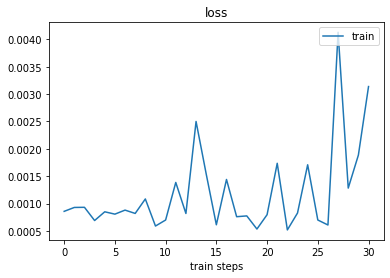

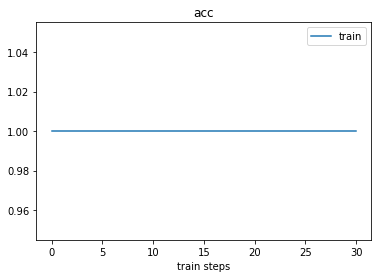

Elapsed 0m 4s

Best train Acc: 1.000000
Best val Acc: 0.000000
Epoch 1/9
----------
tensor([7, 2, 1, 9, 6, 7, 2, 7, 7, 9, 1, 7, 9, 2, 8, 1, 9, 0, 8, 1],
       device='cuda:0')
tensor([4, 1, 6, 5, 2, 3, 8, 6, 1, 2, 0, 9, 4, 9, 8, 9, 5, 1, 1, 9],
       device='cuda:0')
tensor([6, 0, 8, 2, 6, 7, 3, 3, 0, 1, 5, 3, 6, 5, 3, 5, 9, 6, 0, 8],
       device='cuda:0')
tensor([6, 3, 6, 1, 4, 8, 3, 2, 7, 7, 9, 2, 4, 3, 4, 7, 4, 5, 1, 5],
       device='cuda:0')
tensor([0, 2, 6, 2, 1, 4, 9, 3, 5, 4, 5, 8, 1, 7, 1, 7, 8, 0, 1, 5],
       device='cuda:0')
tensor([0, 5, 6, 0, 5, 3, 5, 0, 4, 7, 9, 8, 6, 8, 8, 3, 2, 6, 3, 8],
       device='cuda:0')
tensor([8, 7, 8, 5, 7, 3, 2, 3, 6, 0, 4, 4, 3, 2, 3, 9, 5, 6, 1, 6],
       device='cuda:0')
tensor([8, 6, 0, 7, 4, 2, 1, 5, 4, 4, 0, 9, 9, 8, 0, 7, 8, 9, 8, 7],
       device='cuda:0')
tensor([5, 1, 7, 5, 4, 4, 0, 8, 2, 2, 2, 5, 1, 6, 7, 3, 5, 9, 7, 2],
       device='cuda:0')
tensor([9, 7, 0, 1, 9, 6, 2, 6, 8, 6, 8, 5, 8, 4, 6, 6, 1, 1, 9, 2],
       dev

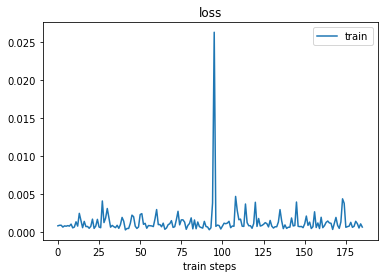

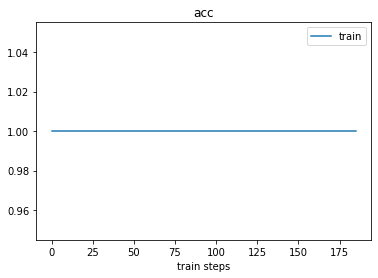

Elapsed 0m 20s

Best train Acc: 1.000000
Best val Acc: 0.000000
Epoch 6/9
----------
tensor([1, 5, 4, 3, 4, 9, 2, 8, 3, 1, 7, 2, 1, 3, 3, 5, 9, 6, 0, 1],
       device='cuda:0')
tensor([7, 8, 1, 8, 1, 9, 6, 3, 2, 3, 7, 1, 9, 1, 0, 9, 1, 9, 4, 0],
       device='cuda:0')
tensor([3, 3, 5, 7, 4, 2, 6, 6, 6, 0, 8, 8, 1, 0, 8, 4, 8, 1, 1, 4],
       device='cuda:0')
tensor([2, 6, 3, 5, 8, 9, 1, 5, 9, 3, 5, 9, 8, 7, 4, 5, 6, 9, 7, 3],
       device='cuda:0')
tensor([3, 2, 4, 0, 7, 0, 9, 7, 0, 6, 6, 8, 9, 3, 5, 6, 5, 2, 6, 6],
       device='cuda:0')
tensor([2, 9, 8, 6, 1, 5, 7, 9, 1, 9, 3, 2, 4, 9, 7, 2, 6, 5, 8, 9],
       device='cuda:0')
tensor([4, 0, 6, 6, 4, 6, 5, 3, 1, 2, 9, 1, 6, 8, 4, 8, 8, 7, 0, 3],
       device='cuda:0')
tensor([3, 3, 2, 3, 6, 2, 7, 4, 1, 6, 9, 0, 1, 6, 2, 3, 2, 9, 4, 3],
       device='cuda:0')
tensor([4, 3, 8, 5, 7, 8, 9, 2, 8, 1, 6, 2, 6, 2, 4, 7, 1, 9, 5, 9],
       device='cuda:0')
tensor([7, 3, 3, 3, 8, 9, 8, 1, 2, 4, 7, 9, 9, 5, 5, 8, 5, 3, 4, 5],
       de

In [ ]:
criterion = nn.CrossEntropyLoss()
model_ft = train_model(model, criterion, optimizer,  dataloader_train, dataloader_test, num_epochs=10)

In [ ]:
def train_model(model, criterion, optimizer,  dataloader_train, dataloader_test, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        model.train()
        for data in dataloader_train:
            # get the inputs
            inputs, labels = data

            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            print(preds)
               
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            
            train_acc.append(torch.sum(preds == labels).type(torch.float)/len(labels))
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels).type(torch.float)
            
        epoch_loss = running_loss / dataset_size_train
        epoch_acc = running_corrects / dataset_size_train

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        valid_loss = 0.0
        running_corrects_valid = 0

        model.eval()     # Optional when not using Model Specific layer
        for data, labels in dataloader_test:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            target = model(data)
            print(labels)
            print(target.shape)
            print(target)
            _, preds = torch.max(target, 1)
            running_corrects_valid += torch.sum(preds == labels).type(torch.float)
        epoch_loss_valid = valid_loss / dataset_size_test
        epoch_acc = running_corrects_valid / dataset_size_test

        if epoch % 5 == 0:
          plot_history(train_loss)
          plot_history(train_acc, 'acc')
          best_model_wts = model.state_dict()
          torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, '/content/gdrive/MyDrive/faces_model_weights/bestmodel{}.pth'.format(str(epoch)))


        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best train Acc: {:4f}'.format(best_acc))
        print('Best val Acc: {:4f}'.format(epoch_acc))

    # load best model weights
    return model
  

## Увеличенное время работы

Все среды выполнения Colab по прошествии определенного времени сбрасываются &#40;если в среде не выполняется код, это происходит быстрее&#41;. Хотя и Colab Pro предполагает лимит на использование сред, этот лимит примерно в два раза выше, чем в рамках обычной версии.

## Лимиты использования ресурсов в Colab Pro

Подписка Colab Pro не предусматривает неограниченного доступа к ресурсам. Чтобы максимально эффективно использовать ресурсы Colab Pro, задействуйте их по мере необходимости, например используйте среды выполнения с большим объемом ОЗУ и графические процессоры только в том случае, если это действительно нужно, и закрывайте вкладки Colab после завершения работы.


## Поделитесь своим мнением

<p>Если у вас есть вопросы или предложения, свяжитесь с нами. Лучше всего использовать меню "Справка &#62; Отправить отзыв". Если вы достигнете лимита на использование в Colab Pro и вам потребуется продукт с более высоким лимитом, сообщите нам об этом.</p>
<p>Если при работе с Colab Pro у вас возникнут проблемы с оплатой, отправьте письмо на адрес <a href="mailto:colab-billing@google.com">colab-billing@google.com</a>.</p>